In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CAModel import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 1
N_ITERS = 50           # Iterations before applying the loss
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

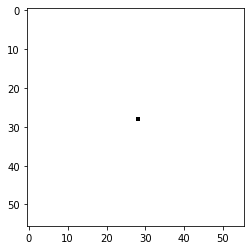

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

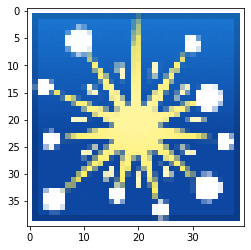

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Custom loss function
class loss_fn:
    """Custom l2 or l1 loss function"""
    def __init__(self, target, order=2):
        self.order = order
        self.target = target
        
    def __call__(self, x):
        return torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order)

target = target.cpu()
loss_fn(Pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

tensor(0.2883)

In [16]:
class loss:

    def __init__(self, target, order=2):

        self.order = order
        self.target = target

    def __call__(self, x, batch_size=BATCH_SIZE):

        losses = None
        with torch.no_grad():
            losses = [torch.mean(torch.abs(x[i, :4, :, :] - self.target)**self.order) for i in range(batch_size)]

        loss = torch.mean(torch.Tensor(losses))
        loss.requires_grad = True

        return loss, losses


def batch_losses(x, target, batch_size=BATCH_SIZE, order=2):

    with torch.no_grad():
        losses = [torch.mean(torch.abs(x[i, :4, :, :] - self.target)**self.order) for i in range(batch_size)] \
               if batch_size > 1 else None

def idx_max_loss(losses):

    if losses is not None:
        return losses.index(max(losses))


In [7]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

target = target.to(device)
model = CAModel().to(device)

In [8]:
device

device(type='cuda')

In [9]:
# loads a pretrained model
model.load("not_persistent.pt")

In [10]:
# Make evolution video
model.makeVideo(video_size=IMAGE_SIZE, n_iters=N_ITERS*2, fps=10, rescaling=8)

/home/macro/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
# Train the model
optimizer = torch.optim.Adam(model.parameters())
criterion = loss_fn(Pad(target, TARGET_PADDING), order=1)
model.train()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000], gamma=0.2)
losses = []
for i in range(100):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
    
    loss = criterion(inputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

In [17]:
# Train the model
optimizer = torch.optim.Adam(model.parameters())
criterion = loss(Pad(target, TARGET_PADDING), order=1)
model.train()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000], gamma=0.2)
losses = []
for i in range(100):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
    
    batch_avg_loss, batch_losses = criterion(inputs, batch_size=BATCH_SIZE)

    print(inputs.is_cuda)
    inputs = inputs.to(cpu)
    print(inputs.is_cuda)

    if BATCH_SIZE > 1:
        where_max_loss = idx_max_loss(batch_losses)
        pool.update(MakeSeed(1, N_CHANNELS, IMAGE_SIZE), indexes[where_max_loss])
        pool.update(inputs[np.where(indexes!=indexes[where_max_loss])], np.where(indexes!=indexes[where_max_loss]))
    else:
        pool.update(inputs, indexes)


    batch_avg_loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(batch_avg_loss.item())

    print(i)

True
False
0
True
False
1


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 700.11 MiB already allocated; 30.25 MiB free; 702.00 MiB reserved in total by PyTorch)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
pl.plot(losses)

In [ ]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

In [ ]:
# Plots the true emoji
imshow(Pad(target, TARGET_PADDING))